<a href="https://colab.research.google.com/github/akimotolab/Policy_Optimization_Tutorial/blob/main/2_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 準備

まず，必要なパッケージのインストールとインポート，および仮想displayを設定します．

In [1]:
# 必要なパッケージのインストール
!apt update
!pip install swig
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gymnasium[box2d]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [46.8 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,194 kB]
Get:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://ppa.launchpadcontent.net/c2d4u.

In [2]:
from pyvirtualdisplay import Display
import torch

# 仮想ディスプレイの設定
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [3]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
import gymnasium as gym
from IPython import display

続いて，第１回の資料で定義した`rollout`などの基本的な関数をここでも定義しておきます．

In [4]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []

    # 乱数の設定
    if seed is not None:
        random.seed(int(seed))
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)

    # 可視化用の設定
    if render:
        d = Display()
        d.start()
        img.append(env.render())

    # メインループ（環境とのインタラクション）
    terminated = False
    truncated = False
    while not (terminated or truncated):

        # 行動を選択
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)

        # 行動を実行
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        observation = next_observation
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

# 方策勾配を用いた方策最適化（強化学習）

今回は「方策勾配法」を見ていきます．
第１回は，汎用的なブラックボックス最適化法を用いた方策最適化の例を見てもらいました．
ブラックボックス最適化法を用いていたということは，目的関数$J(\theta)$が「何らかの方策をパラメータ$\theta$で用いた場合に，環境とインタラクションした結果得られる累積報酬」を意味しているという情報を用いずに，ただブラックボックスな関数として最適化していることを意味します．
ここでは，積極的にこの知識を活用していく方法を検討していきましょう．
ブラックボックス最適化としての方策最適化と，強化学習を用いた方策最適化の一番の違いがここにあります．

## 状態と行動の価値

ブラックボックスな目的関数$J(\theta)$では，一連のインタラクションを通して得られた報酬の合計を評価しています．
これは，最大化したい指標であることに間違いありませんが，一方で，各状態でとった各行動が良かったのかどうか，という情報を与えてくれません．
この情報を活用することができれば，ある状態$s$ではある行動$a$を取るとよい，ということがわかり，その確率を高くするように方策を改善することができそうです．

### 定式化
まず，最低限の定式化を行います．
今回対象としている方策最適化では，
まず初期状態$s_0$を観測します．
初期状態は確率分布$p_0$からランダムに生成されます．
方策を通して，次にとる行動$a_0 \sim \pi(\cdot \mid s_0)$を決定します．
ここでは，方策として確率的な方策を考えることにします．
この行動を実行すると，状態が$s_1$に変わり，これを観測します．
それと同時に，$s_0$で行動$a_0$を取ることの良さを表す即時報酬$r_1$が得られます．
次状態と即時報酬は，環境が定める条件付き確率$p_T(s_1, r_1 \mid s_0, a_0)$により定まります．
このあとは，$s_1$において方策に従って次の行動$a_1 \sim \pi(\cdot \mid s_0)$を決定し，次状態と即時報酬を観測する，というステップを繰り返します．
この環境との一度のインタラクションをステップと呼びます．

注意：「環境が定める」といっても，実際に報酬を設計するのは自分自身（設計者）です．望ましい方策を得るためには，適切な報酬を設計することが極めて重要です．）

### 累積報酬
強化学習においては，方策最適化の目的は割引累積報酬の期待値を最大化することと一般に定められます．
あるステップ$t$において，その先に得られる割引累積報酬は
$$
G_t = r_{t+1} + \gamma r_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^{k} r_{t+1+k}
$$
と定義されます．ここで，$\gamma \in [0, 1]$は割引率と呼ばれるパラメータです．
方策，初期状態分布，状態遷移，即時報酬は確率的ですから，$G_t$自体も確率的に振る舞います．
そこで，これの期待値$\mathrm{E}[G_0]$を考え，これを最大化することを考えます．

ここでは，インタラクションが無限に続くことを想定して$G_t$が定義されています．
この場合，割引率は$\gamma < 1$であることが必要です．
エピソディックタスクの場合，特別な終了状態（例えば迷路のような問題において，ゴール状態に到達した，落とし穴に落ちて脱落した，など）があり，途中でエピソードが止まることになります．
この場合にも，終了状態に達したあとは何をしても終了状態に遷移し，即時報酬はずっと0である，と考えれば，上の定義に当てはまります．
このように，インタラクションに一区切りがあるようなタスクはエピソディックタスクと呼ばれ，この一区切りのステップのまとまりをエピソードと呼びます．
最適化（学習）の都合上，特定のステップでインタラクションを打ち切り，無理やりエピソディックタスクにするような場合もありますが，この場合にも目的は$\mathrm{E}[G_0]$の最大化である（有限ステップでの累積報酬ではない）と考えると，以下の議論が成立します．

注意：制限時間などのように，特定のステップがすぎると強制的に状態がリセットされるようなケースの場合，注意が必要です．この場合，残り時間などを状態観測に含めることが必要になります．

### 状態価値と行動価値

状態$s$の価値を，「$s_0 = s$からインタラクションを始めて，方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s]$」と定義します．
これを$V^{\pi}(s)$と書きます．
定義からわかるように，状態価値は方策$\pi$に依存しています．
割引累積報酬が
$$
G_{t} = r_{t+1} + \gamma G_{t+1}
$$
という再帰的な関係式を満たすことを考えると，状態価値は
$$
V^{\pi}(s) = \mathrm{E}[r_{1} + \gamma V^{\pi}(s_{1}) \mid s_0 = s]
$$
という関係式を満たすことがわかります．
なお，ステップのインデックスに関しては
$$
V^{\pi}(s) = \mathrm{E}[r_{t+1} + \gamma V^{\pi}(s_{t+1}) \mid s_t = s]
$$
と考えても構いません．
状態の価値が高いということは，その方策に従っている場合には，その状態からは得られる割引累積報酬の期待値が高いということを意味しています．
ですから，そのような状態を積極的に訪問したいという指針になるでしょう．

関連して，行動価値（状態行動価値とも言います）を，「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義します．
これを$Q^{\pi}(s, a)$と書きます．
定義からわかるように，もしも最初の行動を$a \sim \pi(\cdot \mid s)$にしたがって決定していれば行動価値関数の$a \sim \pi(\cdot \mid s)$についての期待値は，状態$s$の価値
$$
V^\pi(s) = \mathrm{E}[Q^{\pi}(s, a) \mid a \sim \pi(\cdot \mid s)]
$$
に一致します．

価値関数はいずれも解析的に得られるものではありません．
しかし，インタラクションを通して，近似していくことが可能です．
その代表的な方法の一つに，TD誤差を用いた更新があります．

## 方策勾配

目的関数を数値的に最適化する際，まず考えられる方針は勾配法を用いることです．
すなわち，$\theta \leftarrow \theta + \alpha_\theta \nabla_\theta J(\theta)$と更新する方法です．
割引累積報酬をブラックボックスと捉えてしまうと勾配は計算できないのですが，価値関数を明示的に使うことで勾配をうまく近似することが可能です．
「方策勾配定理」は，割引累積報酬の期待値の，方策パラメータについての期待値を書き下す方法を提供してくれます．

### 方策勾配定理

$J(\theta) = \mathrm{E}[V^{\pi}(s) \mid s \sim p_0]$とします．
このとき，
$$
\nabla_\theta J(\theta) = \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi(a \mid s)  \right]
$$
と書き下すことができます．
ここで，上の期待値は，方策$\pi$のもとでの状態訪問確率と行動選択確率について取られています．
実際にインタラクションを通して観測された状態とその状態のもとで方策$\pi$に従って選択された行動を用いれば，右辺は
$$
Q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
で近似することができます．
また，行動価値関数をその近似値で置き換えれば，勾配$\nabla_\theta J(\theta)$の推定値として
$$
\nabla_\theta J(\theta) \approx q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
を得ることができます．
これを用いて，
$$
\theta \leftarrow \theta + \alpha_\theta q^{\pi}(s_t, a_t) \nabla_{\theta} \ln \pi(a_t \mid s_t)
$$
などと方策パラメータを更新していきます．ここで，$\alpha_\theta$は学習率です．


### Softmax方策の例

方策勾配を計算するには，方策の対数の方策パラメータについての勾配を求める必要があります．
ここでは，Softmax方策を用いた場合について考えてみましょう．
以下にまずSoftmax方策を再掲します．
$$
\pi(a=k \mid \mathbf{s}) = \frac{ \exp( \mathbf{w}_k^\mathrm{T} \mathbf{s} + b_k) }{ \sum_{i=1}^{N_a} \exp( \mathbf{w}_i^\mathrm{T} \mathbf{s} + b_i) }
$$
ここで，$N_a$は選択できる行動の数，$D_s$は状態の次元数を表すものとします．
表記を簡単にするため，$\bar{\mathbf{s}} = [1, s_1, \dots, s_{D_s}]^\mathrm{T}$， $\bar{\mathbf{w}}_k = [b_k, w_{k,1}, \dots, w_{k,D_s}]^\mathrm{T}$と表すことにします．
このとき，Softmax方策は
$$
\pi(a=k \mid \mathbf{s}) = \frac{ \exp( \bar{\mathbf{w}}_k^\mathrm{T} \bar{\mathbf{s}}) }{ \sum_{i=1}^{D_a} \exp( \bar{\mathbf{w}}_k^\mathrm{T} \bar{\mathbf{s}} ) }
$$
これについて，対数をとり，勾配を計算すると，以下を得ます．
$$
\nabla_{\bar{\mathbf{w}}_\ell} \log \pi(a = k \mid \mathbf{s}) =
\begin{cases}
- \pi(a = \ell \mid \mathbf{s}) \bar{\mathbf{s}} & \ell \neq k
\\
(1 - \pi(a = k \mid \mathbf{s})) \bar{\mathbf{s}} & \ell = k
\end{cases}
$$
このように，方策は利用者が決めるものですから，その勾配は解析的に求まるか数値的に効率よく計算することが可能であることが多いです．



In [6]:
class SoftmaxPolicy:
    def __init__(self, dim_state, num_action, init_theta):
        self.num_action = num_action
        self.dim_state = dim_state
        self.w = np.zeros((num_action, dim_state))
        self.b = np.zeros(num_action)
        self.b[1:] = init_theta[:num_action-1]
        self.w[1:, :] = init_theta[num_action-1:].reshape((num_action - 1, dim_state))

    def __call__(self, observation):
        prob = self.get_prob(observation)
        return random.choices(list(range(len(prob))), prob)[0]

    def get_prob(self, observation):
        logit = np.dot(self.w, observation) + self.b
        prob = softmax(logit)
        return prob

    def get_theta(self):
        ds = self.dim_state
        theta = np.zeros(self.w.size + self.b.size - self.w.shape[1] - 1)
        for i in range(len(self.b) - 1):
            theta[i * (ds + 1)] = self.b[i+1]
            theta[i * (ds + 1) + 1: (i + 1) * (ds + 1)] = self.w[i+1]
        return theta

    def set_theta(self, theta):
        ds = self.dim_state
        for i in range(len(self.b) - 1):
            self.b[i+1] = theta[i * (ds + 1)]
            self.w[i+1] = theta[i * (ds + 1) + 1: (i + 1) * (ds + 1)]

    def get_gradient(self, observation, action):
        dtheta = np.zeros(self.w.size + self.b.size - self.w.shape[1] - 1)
        prob = self.get_prob(observation)
        ds = self.dim_state
        for i in range(len(self.b) - 1):
            dtheta[i * (ds + 1)] = int(action == i+1) - prob[action]
            dtheta[i * (ds + 1) + 1: (i + 1) * (ds + 1)] = (int(action == i+1) - prob[action]) * observation
        return dtheta

勾配の値を確認してみましょう．
ここでは後にLunarLander-v2を利用することを想定し，LunarLander-v2での設定で方策を作成しています．
パラメータは全てゼロで初期化しています．

In [7]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)
init_theta = np.zeros(dim_x)
policy = SoftmaxPolicy(dim_state, num_action, init_theta)

print(policy.get_prob(np.zeros(dim_state)))
print(policy.get_gradient(np.zeros(dim_state), 0))
print(policy.get_gradient(np.zeros(dim_state), 1))
print(policy.get_gradient(np.zeros(dim_state), 2))
print(policy.get_gradient(np.zeros(dim_state), 3))

[0.25 0.25 0.25 0.25]
[-0.25 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.25 -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.25 -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.  ]
[ 0.75  0.    0.    0.    0.    0.    0.    0.    0.   -0.25 -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.25 -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.  ]
[-0.25 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    0.75  0.    0.
  0.    0.    0.    0.    0.    0.   -0.25 -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.  ]
[-0.25 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.25 -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.    0.75  0.    0.    0.    0.    0.
  0.    0.    0.  ]


## REINFORCEアルゴリズム（行動価値関数のMonte Carlo推定を用いた方策勾配法）

方策勾配を用いた強化学習の代表的な一つの方法である，REINFORCEアルゴリズムを紹介します．
話を簡単にするために，ここでは

1. エピソディックタスク，
2. 割引率$\gamma = 1$（割引なし），
3. 確率的方策，

であることを仮定します．

方策勾配法を用いる場合，行動価値関数$Q^{\pi}(s_t, a_t)$の近似値$q^{\pi}(s_t, a_t)$を得ることが必要になります．
この$q^{\pi}(s_t, a_t)$の計算方法の違いにより，様々な方策勾配法のバリエーションが存在します．
REINFORCEアルゴリズムでは，Monte-Carlo推定を用いてこれを近似して利用します．

### 行動価値関数のモンテカルロ推定

行動価値関数$Q^{\pi}(s, a)$は「$s_0 = s$からインタラクションを始めて，最初だけ行動$a$を選択し，その後は方策$\pi$に従って行動選択した際に得られる割引累積報酬の期待値$\mathrm{E}[G_0 \mid s_0 = s, a_0 = a]$」と定義されます．
すなわち，この期待値は各ステップ$t$での状態の訪問確率と行動の選択確率を知らなければ計算できません．
行動の選択確率は方策で決まりますから，これは予め知っている情報ですが，ある状態である行動を取った際の次の状態への遷移確率は未知である（実際に実行して始めて次状態を観測できる）と仮定していますから，これを計算することはできません．
期待値を厳密には計算できませんが，実際にインタラクションを通して累積報酬の実現値を観測することは可能です．
これを用いて期待値を推定する方法がモンテカルロ推定です．

状態遷移はステップ数$t$には依存しないため，行動価値関数$Q^{\pi}(s, a)$は$\mathrm{E}[G_t \mid s_t = s, a_t = a]$と定義しても同じものになります．
すなわち，ステップ$t$において観測した状態が$s_t = s$，$a_t = a$であったならば，そこから実際にインタラクションして得られた累積報酬 $G_t = r_{t+1} + \dots + r_{T}$（$T$は終端ステップ）の期待値がその$(s_t, a_t)$の行動価値であり，観測された$G_t$は確率変数として見た場合の$G_t$の観測値（サンプル）であることがわかります．
そのため，観測された$G_t$は行動価値$Q^\pi(s_t, a_t)$の不偏推定値であることになります．
そこで，これを$q^\pi(s_t, a_t)$として採用することにしましょう．


以下の関数では，`rollout`の結果得られる履歴から，各ステップでの将来に得られる累積報酬を計算し，その配列を返します．
終了状態から遡ることで計算することができます．

In [8]:
def monte_carlo_action_value(history):
    T = len(history)
    G = np.zeros(T)
    ID_observation = 0
    ID_action = 1
    ID_next_observation = 2
    ID_reward = 3
    ID_terminated = 4
    ID_truncated = 5
    ID_info = 6
    for k in range(1, T+1):
        if k == 1:
            G[T-k] = history[T-k][ID_reward]
        else:
            G[T-k] = history[T-k][ID_reward] + G[T-k+1]
    return G

### REINFORCEアルゴリズム

REINFORCEアルゴリズムは，価値のモンテカルロ推定を用いた方策勾配法です．
REINFORCEにはいくつかのバリエーションがありますが，ここでは，エピソード単位で方策パラメータを更新する最もシンプルな方法を紹介します．
（なお，状態遷移毎（ステップ毎）にパラメータを更新するバリエーションもあります．）

まず，現在の方策を用いてEエピソード分だけ環境とインタラクションします．
この結果から，エピソード内に訪問した各状態についての価値をモンテカルロ推定します．
この推定価値を用いて，方策勾配を
$$\begin{aligned}
\nabla_\theta J(\theta)
&= \mathrm{E}\left[ Q^{\pi}(s, a) \nabla_{\theta} \ln \pi(a \mid s)  \right] \\
&\approx \frac{1}{E}\sum_{e=1}^{E}\frac{1}{T_e}\sum_{t=1}^{T_e} G_{e,t} \nabla_{\theta} \ln \pi(a_{e,t} \mid s_{e,t}) =: \widehat{\nabla_\theta J(\theta) }
\end{aligned}
$$
と近似し，方策パラメータを$\theta \leftarrow \theta + \eta \widehat{\nabla_\theta J(\theta) }$に従って更新します．
ここで，$\eta > 0$は学習率を表し，問題や方策毎に調整が必要となります．
また，状態，行動，累積報酬にはエピソードのインデックスが追加されており，終了ステップもエピソード毎に異なることに注意してください．

In [9]:
class REINFORCE:
    def __init__(self, policy, lr):
        self.policy = policy
        self.lr = lr

    def update(self, history_list):
        ID_observation = 0
        ID_action = 1
        H = len(history_list)
        theta = self.policy.get_theta()
        dtheta = np.zeros(theta.shape)
        ddtheta = np.zeros(theta.shape)

        for history in history_list:
            T = len(history)
            G = monte_carlo_action_value(history)
            for t in range(T):
                ddtheta += self.policy.get_gradient(history[t][ID_observation], history[t][ID_action]) * G[t]
            dtheta += ddtheta / T

        theta += dtheta * self.lr / H
        self.policy.set_theta(theta)

ここでは，行動が離散となるエピソディックタスクである Lunar Lander を用いて，REINFORCEアルゴリズムによる方策最適化を実行してみます．
方策は前述のSoftmaxPolicyです．

In [10]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)
init_theta = np.zeros(dim_x)
policy = SoftmaxPolicy(dim_state, num_action, init_theta)

H = 10
lr_init = 1e-2
lr_decay_factor = 1.0
lr_decay_interval = 1000
lr_decay_count = 0
max_episode = H * lr_decay_interval * 1

return_array = np.zeros((max_episode // lr_decay_interval + 1, 50))
for i in range(50):
    history, img = rollout(envname, policy=policy, render=False)
    return_array[lr_decay_count, i] = cumulative_reward(history)
print(0, np.mean(return_array[lr_decay_count]), np.std(return_array[lr_decay_count]))

agent = REINFORCE(policy, lr_init)

for e in range(max_episode // H):
    history_list = [rollout(envname, agent.policy)[0] for i in range(H)]
    agent.update(history_list)
    if (e + 1) % lr_decay_interval == 0:
        lr_decay_count += 1
        for i in range(50):
            history, img = rollout(envname, policy=policy, render=False)
            return_array[lr_decay_count, i] = cumulative_reward(history)
        print(lr_decay_count, np.mean(return_array[lr_decay_count]), np.std(return_array[lr_decay_count]))
        agent.lr *= lr_decay_factor

0 -151.49642797835685 101.76987632415785
1 -148.8440354531422 118.37623611351762


<ipython-input-4-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


0 -112.92969316657229 55.48905446116124
1 -135.30722540461414 71.81033374682904


<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


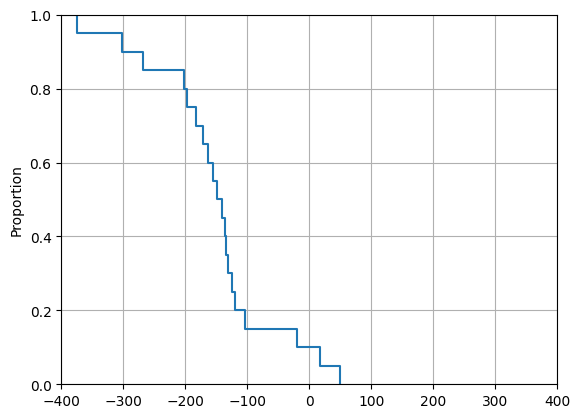

In [ ]:
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=return_array, ax=ax, complementary=True)
ax.set_xlim(-400, 400)
plt.grid()

In [ ]:
avg_cr = 0.0
for e in range(MAX_EPISODE):
    history, img = rollout(envname, agent.policy)
    agent.update(history)
    avg_cr += cumulative_reward(history)
    if (e + 1) % 100 == 0:
        print(1+e, avg_cr/100)
        avg_cr = 0.0

100 -2.6409090832994195
200 -3.2608444146512956
300 -1.736412142947613
400 -2.9418449572485224
500 -0.6129548914231979
600 -1.43992443093755
700 -2.248598511713945
800 -1.4470300606483313
900 -0.5504042600420508
1000 -1.023074350658569
1100 -2.069167244689957
1200 -3.713823378930463
1300 -1.0602275012180424
1400 -1.258684991693486
1500 -3.771487425237965
1600 -0.3611580172213131
1700 -1.5056072847477284
1800 -2.8757991311020192
1900 -1.4463990489870167
2000 -3.80956533263741
2100 -2.492183425842748
2200 -0.6525571773731685
2300 -1.1594187426285323
2400 -1.9029621884732189
2500 -4.101891472989271
2600 -0.6615562421050594
2700 -1.3351419007653798
2800 -1.5398523762515577
2900 -1.8620009775667647
3000 -0.8014655537261163
3100 -2.9507929803349304
3200 -1.154488871814529
3300 -1.0728191361593529
3400 -1.3031035322866429
3500 -1.5209262508856631
3600 -2.3886981111548873
3700 -0.8126813068512722
3800 -1.9345008669205321
3900 -1.9659117668898745
4000 -0.9630210452760223
4100 -2.192383620323489

<ipython-input-15-4731ee719ac9>:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


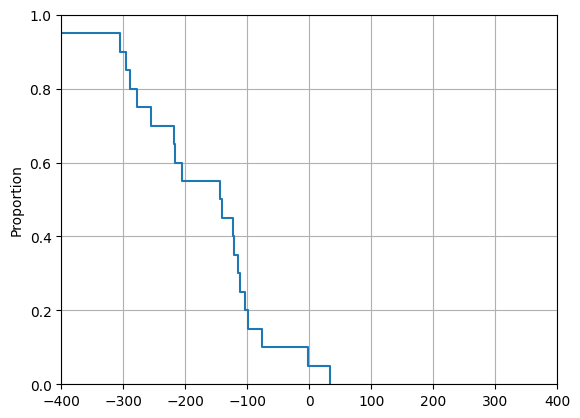

In [ ]:
seed_array = np.arange(100, 2100, 100)
return_array = np.zeros(len(seed_array))
for i, seed in enumerate(seed_array):
    history, img = rollout(envname, policy=agent.policy, render=False, seed=seed)
    return_array[i] = cumulative_reward(history)

fig, ax = plt.subplots()
sns.ecdfplot(data=return_array, ax=ax, complementary=True)
ax.set_xlim(-400, 400)
plt.grid()

In [ ]:
history, img = rollout(envname, policy=agent.policy, render=True)
print(cumulative_reward(history))
visualize(img)

-250.40824657549953



行動価値関数に着目しましょう．
今，行動価値関数を近似する関数$q^\pi(s, a)$を持っているとしましょう．
これを更新して，真の行動価値$Q^{\pi}(s, a)$に近づけることを考えます．
行動価値$Q^{\pi}(s, a)$の満たす再帰式
$$
Q^{\pi}(s, a) = \mathrm{E}[r_{t+1} + \gamma Q^{\pi}(s_{t+1}, a') \mid s_t = s, a' \sim \pi(\cdot\mid s_{t+1})]
$$
を，$q^\pi(s, a)$も満たすように更新していきます．
この際，右辺の期待値は計算できませんが，実際に観測された値を用いて近似すれば，
右辺は
$$
r_{t+1} + \gamma Q^{\pi}(s_{t+1}, a')
$$
となります．ここで，$a' \sim \pi(\cdot\mid s_{t+1})$です．
右辺の$Q^{\pi}$を$q^\pi(s, a)$で置き換えたものを
$$
y = r_{t+1} + \gamma q^{\pi}(s_{t+1}, a')
$$
とします．
再帰式を満たすように，$q^{\pi}(s, a)$が$y$に近づくように$q^{\pi}$を更新します．
$q^{\pi}$がパラメータ$w$を用いてモデル化されているならば，
$$
w \leftarrow w - \frac{\alpha_w}{2}\nabla_w (q^{\pi}(s, a) - y)^2 = w -  \alpha_w (q^{\pi}(s, a) - y) \nabla_w q^{\pi}(s, a)
$$
などと更新します．ここで，$\alpha_w$は学習率を表します．

## 使用環境：Lunar Lander（連続状態，離散行動）


In [ ]:
import random
import numpy as np
from scipy.special import softmax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym
from IPython import display

In [ ]:
def rollout(envname, policy=None, render=False, seed=None):
    if render:
        env = gym.make(envname, render_mode="rgb_array")
    else:
        env = gym.make(envname)
    history = []
    img = []
    if seed is not None:
        random.seed(seed)
    envseed = random.randint(0, 1000)
    actseed = random.randint(0, 1000)
    observation, info = env.reset(seed=envseed)
    env.action_space.seed(actseed)
    if render:
        d = Display()
        d.start()
        img.append(env.render())
    terminated = False
    truncated = False
    while not (terminated or truncated):
        if policy is None:
            action = env.action_space.sample()
        else:
            action = policy(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        history.append([observation, action, next_observation, reward, terminated, truncated, info])
        if render:
            display.clear_output(wait=True)
            img.append(env.render())
    env.close()
    return history, img


def visualize(img):
    dpi = 72
    interval = 50
    plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
    patch = plt.imshow(img[0])
    plt.axis=('off')
    animate = lambda i: patch.set_data(img[i])
    ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
    display.display(display.HTML(ani.to_jshtml()))
    plt.close()


def cumulative_reward(history):
    return sum(hist[3] for hist in history)

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
w = np.random.randn(num_action, dim_state)
b = np.random.randn(num_action)
policy = SoftmaxPolicy(w, b)
history, img = rollout(envname, policy, render=True)
visualize(img)

In [ ]:
cumulative_reward(history)

In [ ]:
class ES:
    def __init__(self, init_s, init_x, init_fx):
        self.fx = init_fx
        self.x = np.array(init_x, copy=True)
        self.s = init_s
        self.dim = len(self.x)
        self.alpha = np.exp(1.0 / self.dim)
        self.y = np.empty(self.dim)

    def ask(self):
        self.y = self.x + self.s * np.random.randn(self.dim)
        return self.y

    def tell(self, fx):
        if self.fx < fx:
            self.s /= self.alpha**(0.25)
        else:
            self.s *= self.alpha
            self.x = self.y
            self.fx = fx

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_x = (1 + dim_state) * (num_action - 1)


def objective(x):
    w, b = SoftmaxPolicy.x2wb(x)
    policy = SoftmaxPolicy(w, b)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history)


sigma = 1.0
mean = np.zeros(dim_x)
f_hist = np.empty(2000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])

In [ ]:
plt.plot(f_hist)

In [ ]:
policy = SoftmaxPolicy(*SoftmaxPolicy.x2wb(es.x))
history, img = rollout(envname, policy, seed=100, render=True)
visualize(img)
cumulative_reward(history)

In [ ]:
class MultiLayerSoftmaxPolicy:
    def __init__(self, dim_array):
        self.w_list = []
        self.b_list = []
        self.dim_array = dim_array
        for i in range(len(dim_array)-1):
            self.w_list.append(np.zeros((dim_array[i+1], dim_array[i])))
            self.b_list.append(np.zeros(dim_array[i+1]))

    def __call__(self, observation):
        z = np.array(observation, copy=True)
        for i in range(len(self.dim_array)-2):
            z = np.dot(self.w_list[i], z) + self.b_list[i]
            z = np.fmax(z, 0)
        z = np.dot(self.w_list[-1], z) + self.b_list[-1]
        prob = softmax(z)
        return random.choices(list(range(len(prob))), prob)[0]

    def set_param(self, x):
        n = 0
        for i in range(len(self.dim_array)-1):
            dim1 = self.dim_array[i+1]
            dim0 = self.dim_array[i]
            self.w_list[i] = x[n:n + dim1 * dim0].reshape((dim1, dim0))
            self.b_list[i] = x[n + dim1 * dim0:n + dim1 * (dim0 + 1)]
            n += dim1 * (dim0 + 1)
        # dim1 = self.dim_array[-1] - 1
        # dim0 = self.dim_array[-2]
        # self.w_list[-1][1:, :] = x[n:n + dim1 * dim0].reshape((dim1, dim0))
        # self.b_list[-1][1:] = x[n + dim1 * dim0:n + dim1 * (dim0 + 1)]

In [ ]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
dim_array = [8, 20, 20, 4]
dim_x = 0
for i in range(len(dim_array) - 1):
    dim1 = dim_array[i+1]
    # if i == len(dim_array) - 1:
    #     dim1 -= 1
    dim0 = dim_array[i]
    dim_x += dim1 * (dim0 + 1)

def objective(x):
    policy = MultiLayerSoftmaxPolicy(dim_array)
    policy.set_param(x)
    history, img = rollout(envname, policy, seed=100)
    return -cumulative_reward(history) + 1e-2 * np.dot(x, x)

sigma = 0.1
mean = sigma * np.random.randn(dim_x)
f_hist = np.empty(10000)
f_hist[0] = objective(mean)
es = ES(sigma, mean, f_hist[0])
for t in range(1, len(f_hist)):
    w = es.ask()
    f_hist[t] = objective(w)
    es.tell(f_hist[t])


In [ ]:
plt.plot(f_hist)

In [ ]:
policy = MultiLayerSoftmaxPolicy(dim_array)
policy.set_param(es.x)
history, img = rollout(envname, policy, seed=100, render=True)
visualize(img)
cumulative_reward(history)

In [ ]:
policy = MultiLayerSoftmaxPolicy(dim_array)
policy.set_param(es.x)
history, img = rollout(envname, policy, seed=None)
cumulative_reward(history)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

In [12]:
class Policy(nn.Module):
    def __init__(self, dim_state, num_action, dim_hidden=16):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(dim_state, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, dim_hidden)
        self.fc3 = nn.Linear(dim_hidden, dim_hidden)
        self.fc4 = nn.Linear(dim_hidden, num_action)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=0)
        return x

In [49]:
class ReinforceAgent:
    def __init__(self, env, model, lr=5e-4, gamma=0.99):
        self.policy = model
        self.env = env
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma

    def __call__(self, observation):
        return self.select_action(observation)[0]

    def select_action(self, observation):
        observation_ = Variable(torch.Tensor(observation))
        action_probs = self.policy(observation_)
        log_probs = action_probs.log()
        action = Categorical(action_probs).sample()
        return action.data.cpu().numpy(), log_probs[action]

    def rollout(self):
        observation, info = self.env.reset()
        steps = 0
        rewards = []
        log_probs = []
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action, log_prob = self.select_action(observation)
            next_observation, reward, terminated, truncated, info = self.env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            observation = next_observation
            steps +=1
        return rewards, log_probs

    def update(self, rewards, log_probs):
        G = torch.zeros(1, 1).type(torch.FloatTensor)
        loss = 0
        for i in reversed(range(len(rewards))):
            G = rewards[i] + self.gamma * G
            loss = loss - (log_probs[i] * Variable(G))
        loss = loss / len(rewards)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [50]:
envname = "LunarLander-v2"
dim_state = 8
num_action = 4
env = gym.make(envname)

model = Policy(dim_state = 8, num_action = 4)
agent = ReinforceAgent(env, model)

In [51]:
for i in range(10000):
    rewards, log_probs = agent.rollout()
    agent.update(rewards, log_probs)

In [48]:
history, img = rollout(envname, policy=agent, render=True)
print(cumulative_reward(history))
visualize(img)

-379.5184883054701
